In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#Plotting libraries
import seaborn as sn
import matplotlib.pyplot as plt


# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/allstate-claims-severity/train.csv
/kaggle/input/allstate-claims-severity/train.csv.zip
/kaggle/input/allstate-claims-severity/test.csv.zip
/kaggle/input/allstate-claims-severity/sample_submission.csv.zip
/kaggle/input/allstate-claims-severity/test.csv
/kaggle/input/allstate-claims-severity/sample_submission.csv


# 1. DATA PREPROCESSING

This data contains categorical and continuous values. Each row in this dataset represents an insurance claim. I will predict the value for the 'loss' column. However, I need to account for skewness and correlation before moving ahead.

In [26]:
#Reading dataset
df=pd.read_csv("../input/allstate-claims-severity/train.csv")
df_test=pd.read_csv("../input/allstate-claims-severity/test.csv")

In [27]:
df

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188313,587620,A,B,A,A,A,A,A,A,B,...,0.242437,0.289949,0.24564,0.30859,0.32935,0.223038,0.220003,0.333292,0.208216,1198.62
188314,587624,A,A,A,A,A,B,A,A,A,...,0.334270,0.382000,0.63475,0.40455,0.47779,0.307628,0.301921,0.318646,0.305872,1108.34
188315,587630,A,B,A,A,A,A,A,B,B,...,0.345883,0.370534,0.24564,0.45808,0.47779,0.445614,0.443374,0.339244,0.503888,5762.64
188316,587632,A,B,A,A,A,A,A,A,B,...,0.704364,0.562866,0.34987,0.44767,0.53881,0.863052,0.852865,0.654753,0.721707,1562.87


In [28]:
#Dropping first column as it is not needed
df=df.drop('id',axis=1)
pdf=df_test['id']
df_test=df_test.drop('id',axis=1)

In [29]:
#Checking skewness
print(df.skew())

cont1     0.516424
cont2    -0.310941
cont3    -0.010002
cont4     0.416096
cont5     0.681622
cont6     0.461214
cont7     0.826053
cont8     0.676634
cont9     1.072429
cont10    0.355001
cont11    0.280821
cont12    0.291992
cont13    0.380742
cont14    0.248674
loss      3.794958
dtype: float64


In [30]:
#Loss has significant skew, and hence must be transformed.
df["loss"] = np.log(df["loss"]+1)
print(df.loss.skew())

0.0966195895031505


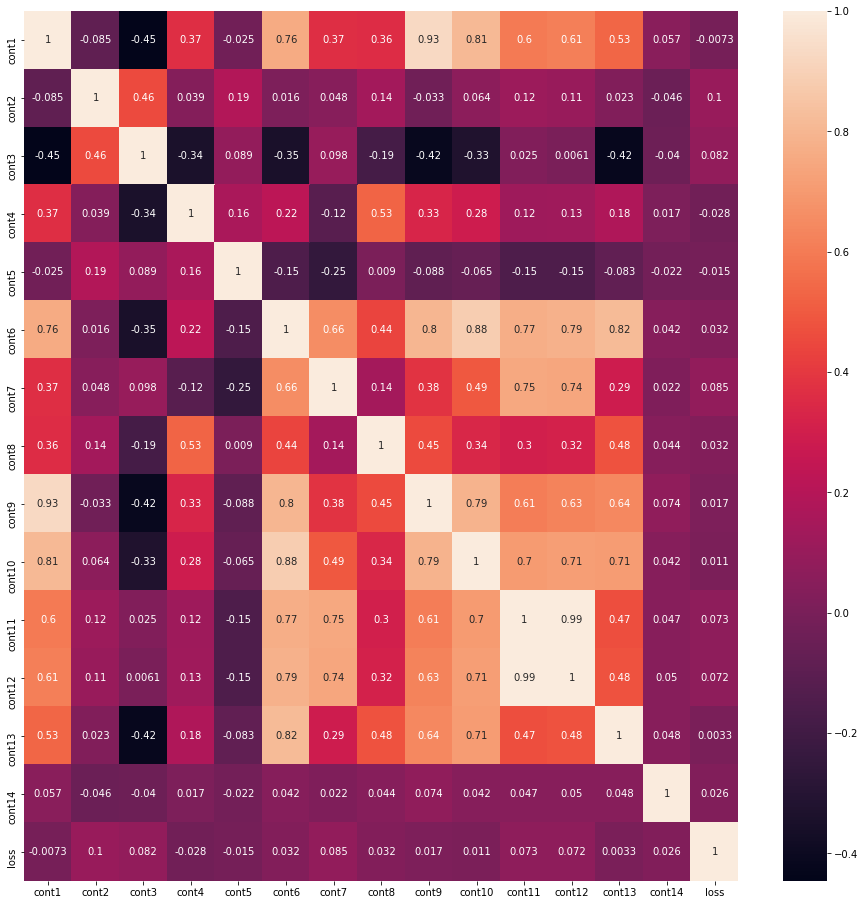

In [31]:
#Data correlation
corrMatrix = df.corr()
plt.figure(figsize = (16,16))
ax=sn.heatmap(corrMatrix, annot=True)
plt.show()

In [32]:
# Select upper triangle of correlation matrix
upper = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

# Drop features 
df.drop(to_drop, axis=1, inplace=True)

# 2. Data Preparation

Coming to categorical data, it needs to be one hot encoded. Then, I split the data into train and validation.

In [33]:
#One hot encoding all categorical attributes
one_hot_encoded_training_predictors = pd.get_dummies(df)
one_hot_encoded_test_predictors = pd.get_dummies(df_test)
df_train, df_test = one_hot_encoded_training_predictors.align(one_hot_encoded_test_predictors,
                                                                    join='left', 
                                                                    axis=1)

In [38]:
df_train.iloc[:,:20]

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont11,cont13,cont14,loss,cat1_A,cat1_B,cat2_A,cat2_B,cat3_A,cat3_B,cat4_A,cat4_B
0,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.569745,0.822493,0.714843,7.702637,1,0,0,1,1,0,0,1
1,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.338312,0.611431,0.304496,7.158203,1,0,0,1,1,0,1,0
2,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.381398,0.195709,0.774425,8.008396,1,0,0,1,1,0,1,0
3,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.327915,0.605077,0.602642,6.846784,0,1,0,1,1,0,0,1
4,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.204687,0.246011,0.432606,7.924742,1,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188313,0.347403,0.785784,0.613660,0.473202,0.939556,0.242437,0.289949,0.24564,0.223038,0.333292,0.208216,7.089760,1,0,0,1,1,0,1,0
188314,0.507661,0.555782,0.549770,0.802892,0.704268,0.334270,0.382000,0.63475,0.307628,0.318646,0.305872,7.011521,1,0,1,0,1,0,1,0
188315,0.484469,0.785784,0.792378,0.189137,0.482436,0.345883,0.370534,0.24564,0.445614,0.339244,0.503888,8.659324,1,0,0,1,1,0,1,0
188316,0.438385,0.422197,0.298977,0.383428,0.340543,0.704364,0.562866,0.34987,0.863052,0.654753,0.721707,7.354919,1,0,0,1,1,0,1,0


In [35]:
#Splitting dataset into training and validation
Y=df_train['loss']
X=df_train.drop('loss',axis=1)
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, train_size=0.8, random_state=0)

# 3. Model Training

Finally comes training the model and making predictions on validation set. Considering the vast size of this dataset, my first choice would be a neural network. However, given the time constraint, I decided to go for XGBoost regression. I didn't get to toy around with the hyperparamters much, but the results are satisfactory, considering the optimal result in the competition associated with this dataset was 1109.70772

In [36]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
# fit model no training data
model = XGBRegressor(n_estimators=1000, learning_rate=0.1)
model.fit(X_train, Y_train)
# make predictions for test data
y_pred = model.predict(X_val)
# evaluate predictions
mae=mean_absolute_error(np.expm1(Y_val), np.expm1(y_pred))
print(mae)

1158.4192181550757


# 4. Model Predictions

In [39]:
X_test=df_test.drop('loss',axis=1)
Test_pred=np.expm1(model.predict(X_test))
print(Test_pred)

[1453.8765 1947.0869 8687.724  ... 2364.884   890.6853 3073.5398]
